## Analog discovery using Simba

In this notebook we carry out an analog discovery task using as library MassSpecGym data and as query data CASMI2022 data,

In [1]:
%load_ext autoreload
%autoreload 2

## Libraries

In [2]:
import simba
from simba.config import Config
from simba.simba.simba import Simba
from simba.simba.preprocessing_simba import PreprocessingSimba
from simba.simba.plotting import Plotting
from simba.simba.analog_discovery import AnalogDiscovery
import numpy as np
import spectrum_utils.plot as sup
from rdkit import Chem
from simba.simba.ground_truth import GroundTruth
import matplotlib.pyplot as plt
import spectrum_utils.plot as sup

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


## Defining parameters

Define the default configuration variables

In [3]:
config=Config()

Location of model saved, reference spectra in mgf file (MASSSPECGYM), an query spectra (CASMI)

In [4]:
model_location= '/Users/sebas/projects/data/best_model_generated_data_20250130.ckpt'
reference_file = '/Users/sebas/projects/data/MassSpecGym.mgf'
casmi_file= '/Users/sebas/projects/data/processed_massformer/spec_df.pkl' 

## Load spectra

Let's load the reference spectra and query spectra. This code already carries out a preprocessing of the files obtaining only protonized adducts and spectra with at least more than 6 peaks.

In [5]:
all_spectrums_reference=PreprocessingSimba.load_spectra(reference_file, config, use_gnps_format=False)

/Users/sebas/projects/data/MassSpecGym.mgf
File name ends with mgf


  0%|▎                                                                                                                                                               | 159139/100000000 [00:44<7:44:33, 3581.91it/s]


We reached the end of the array at index 159139


In [6]:
print(f'Number of spectra loaded from reference: {len(all_spectrums_reference)}')

Number of spectra loaded from reference: 133215


In [7]:
all_spectrums_query=PreprocessingSimba.load_spectra(casmi_file, config, use_gnps_format=False)

/Users/sebas/projects/data/processed_massformer/spec_df.pkl


In [8]:
print(f'Number of spectra loaded from query: {len(all_spectrums_query)}')

Number of spectra loaded from query: 158


##  Let's check some spectra visually

In [9]:
all_spectrums_query[0].params

{'spectrumid': '3 M+H',
 'name': '3 M+H',
 'inchi': '',
 'organism': 'casmi',
 'id': 3,
 'smiles': 'COc1ccc(-c2oc3c(CC=C(C)C)c(O)cc(O)c3c(=O)c2OC2OC(C)C(OC(C)=O)C(OC3OC(CO)C(O)C(O)C3O)C2O)cc1',
 'ionmode': 'Positive',
 'pepmass': [719.253866983956],
 'charge': [1],
 'libraryquality': 1}

<Axes: xlabel='m/z', ylabel='Intensity'>

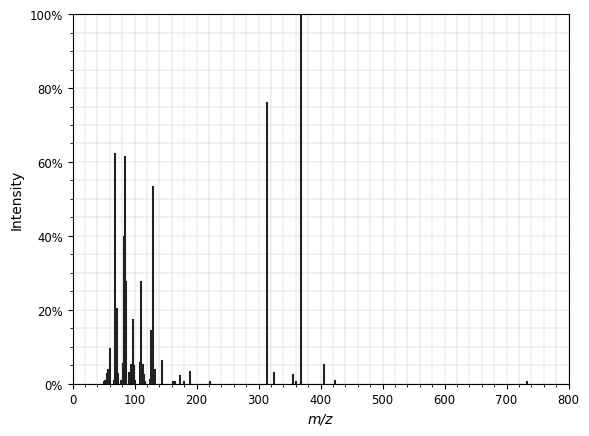

In [10]:
sup.spectrum(all_spectrums_query[0])

## Initialize model

Here we load a simba model based on path specified in 'model_location'. The device to be used is set to 'cpu' unless you have access to a configures GPU. The argument cache_embeddings, allows to reuse embeddings already computed to accelerate future library searchs.

In [11]:
simba_model= Simba(model_location, config=config, device='cpu', cache_embeddings=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Customised penalty matrix: tensor([[1.0000, 0.6400, 0.3600, 0.1600, 0.0400, 0.0000],
        [0.4958, 0.7746, 0.4958, 0.2789, 0.1239, 0.0310],
        [0.2506, 0.4456, 0.6962, 0.4456, 0.2506, 0.1114],
        [0.1114, 0.2506, 0.4456, 0.6962, 0.4456, 0.2506],
        [0.0310, 0.1239, 0.2789, 0.4958, 0.7746, 0.4958],
        [0.0000, 0.0400, 0.1600, 0.3600, 0.6400, 1.0000]])
Customised penalty matrix: tensor([[1.0000, 0.6400, 0.3600, 0.1600, 0.0400, 0.0000],
        [0.4958, 0.7746, 0.4958, 0.2789, 0.1239, 0.0310],
        [0.2506, 0.4456, 0.6962, 0.4456, 0.2506, 0.1114],
        [0.1114, 0.2506, 0.4456, 0.6962, 0.4456, 0.2506],
        [0.0310, 0.1239, 0.2789, 0.4958, 0.7746, 0.4958],
        [0.0000, 0.0400, 0.1600, 0.3600, 0.6400, 1.0000]])


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/core/saving.py:173: Found keys that are in the model state dict but not in the checkpoint: ['log_sigma1', 'log_sigma2']


## Predictions

Based on the simba model created let's predict the substructure edit distance (sim_ed) and MCES distance (sim_mces)

In [ ]:
sim_ed, sim_mces= simba_model.predict(all_spectrums_query, all_spectrums_reference, )

Preprocessing all the data ...


158it [00:00, 66750.61it/s]


Finished preprocessing 
loading data
Normalizing intensities
Preprocessing all the data ...


133215it [00:01, 87569.20it/s]


Finished preprocessing 
loading data


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Normalizing intensities
running
Processing embeddings ...


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

/Users/sebas/projects/metabolomics/simba/transformers/spectrum_transformer_encoder_custom.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mass_precursor = torch.tensor(kwargs["precursor_mass"].float())
/Users/sebas/projects/metabolomics/simba/transformers/spectrum_transformer_encoder_custom.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  charge_precursor = torch.tensor(kwargs["precursor_charge"].float())
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/torch/nn/modules/transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytor

running
Processing embeddings ...


Predicting: |                                                                                                 …

In [ ]:
sim_mces

The predictions of substructure edit distance are discretized between 0 and 5, being 5 having five or more modifications and 0 having zero modifications. Let's take 10,000 random predictions and check the distribution of the results. Higher substructure edit distances are more common since related molecules are scarse normally.

In [ ]:
flat = sim_ed.ravel()                            # view as 1-D array of length M*N
idx = np.random.choice(flat.size, size=10000, replace=False)
samples_ed = flat[idx]
plt.hist(samples_ed, bins=20)
plt.grid()
plt.xlabel('substructure edit distance')
plt.ylabel('Frequency')

The predictions of MCES distance are constrained to 0 to 40 edges. Let's take 10,000 random predictions and check the distribution of the results. Higher MCES distances are more common since related molecules are scarse normally.

In [ ]:
flat = sim_mces.ravel()                            # view as 1-D array of length M*N
idx = np.random.choice(flat.size, size=10000, replace=False)
samples_mces = flat[idx]
plt.hist(samples_mces, bins=20)
plt.grid()
plt.xlabel('MCES distance')
plt.ylabel('Frequency')

## Reranking

Based on the predictions of MCES and Edit distance we can rerank the results. Lower MCES distance and lower edit distances are higher in the rank. The MCES distance is used as primary metric to rank the predictions given its finer granularity. If 2 predictions have the same MCES distance, the one with the lower substructure edit distance is ranked higher.

In [ ]:
ranking= AnalogDiscovery.compute_ranking(sim_mces, sim_ed)

The rank is scaled to 0-1 (normalized to the number of comparisons with the reference library), where 1 means the highest ranking and 0 the lowest ranking.

In [ ]:
ranking.shape

In [ ]:
flat = ranking.ravel()                            # view as 1-D array of length M*N
idx = np.random.choice(flat.size, size=10000, replace=False)
samples_mces = flat[idx]
plt.hist(samples_mces, bins=20)
plt.grid()
plt.xlabel('ranking score')
plt.ylabel('Frequency')

## What is the matched spectra in the reference library for each query spectra?

If we want to find this answer, we have to first select the query spectra we are interested. We can define a variable 'target_index' which indicates the position of the spectrum in the spectra loaded. From there, we can select the 10 highest SIMBA scores and filtering the match with the lowest MCES distance

In [ ]:
target_index=1

In [ ]:
spectra_query= all_spectrums_query[target_index]

In [ ]:
Chem.MolFromSmiles(spectra_query.params['smiles'])

Let's checkwhat are the predictions of the model for this specific query spectra. These are the ranking scores generated for the query spectra selected:

In [ ]:
ranking[target_index]

In [ ]:
ranking[target_index].shape

Between all the comparisons, we can select the 10 highest scores

In [ ]:
best_matches= np.argsort(ranking[target_index])[-10:]

In [ ]:
best_matches

In [ ]:
spectra_matches = [all_spectrums_reference[ind] for ind in best_matches]

Let's compute the MCES distances for the matches found and select the best

In [ ]:
ground_truth_mces=GroundTruth.compute_mces([spectra_query], spectra_matches)

In [ ]:
ground_truth_mces

Let's select the lowest MCES distance

In [ ]:
best_match_index = best_matches[np.argmin(ground_truth_mces)]

In [ ]:
best_match_index

In [ ]:
spectra_match= spectra_matches[np.argmin(ground_truth_mces)]

This is the index in the reference spectra with the best match:

In [ ]:
Chem.MolFromSmiles(spectra_match.params['smiles'])

Now take a look at what the model predicts in terms of substructure edit distance and MCES distance for this specfic comparison:

In [ ]:
print(f'The MCES distance predicted is: {np.round(sim_mces[target_index, best_match_index])}')

In [ ]:
print(f'The substructure edit distance predicted is: {sim_ed[target_index, best_match_index]}')

## Comparison with ground truth

We can check what is the ground truth edit distance and MCES distance:

In [ ]:
spectra_query.params

In [ ]:
spectra_match.params

In [ ]:
ground_truth_tanimoto=GroundTruth.compute_tanimoto([spectra_query], [spectra_match])

In [ ]:
print(f'The Tanimoto similarity is: {ground_truth_tanimoto[0,0]:.2f}')

In [ ]:
ground_truth_mces=GroundTruth.compute_mces([spectra_query], [spectra_match])

In [ ]:
print(f'The real MCES distance is: {ground_truth_mces[0,0]}')

In [ ]:
ground_truth_ed=GroundTruth.compute_edit_distance([spectra_query], [spectra_match])

In [ ]:
print(f'The real substructure edit distance is: {ground_truth_ed[0,0]}')

## How it looks like the spectra that is found as match?

In [ ]:
sup.mirror(spectra_query, spectra_match)